<a href="https://colab.research.google.com/github/AnaMariaRoj/DoctorsBackend/blob/main/ProyectoPSIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [10]:
import cv2
import glob

# Rutas de tus carpetas
ruta_normal = "/content/drive/MyDrive/IMAGENES_LISTAS/NORMAL_NORMALIZADA/*.jpeg"
ruta_tb = "/content/drive/MyDrive/IMAGENES_LISTAS/TURBERCULOSIS_NORMALIZADA/*.png"

imagenes_normal = []
imagenes_tb = []

# Cargar imágenes normales
for archivo in glob.glob(ruta_normal):
    img = cv2.imread(archivo, cv2.IMREAD_GRAYSCALE)
    imagenes_normal.append(img)

# Cargar imágenes con tuberculosis
for archivo in glob.glob(ruta_tb):
    img = cv2.imread(archivo, cv2.IMREAD_GRAYSCALE)
    imagenes_tb.append(img)

print("Imágenes normales cargadas:", len(imagenes_normal))
print("Imágenes TB cargadas:", len(imagenes_tb))


Imágenes normales cargadas: 1583
Imágenes TB cargadas: 683


## **Segmentación**

In [166]:
import cv2
import numpy as np

def segmentar_pulmones(img):

    # 1. Suavizado para reducir ruido
    blur = cv2.GaussianBlur(img, (7,7), 0)

    # 2. Ecualización del contraste
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    ecualizada = clahe.apply(blur)

    # 3. Umbralización Otsu invertida (pulmones oscuros)
    _, thresh = cv2.threshold(ecualizada, 0, 255,
                              cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 4. Morfología
    kernel = np.ones((9,9), np.uint8)

    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,
                               kernel, iterations=1)

    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE,
                               kernel, iterations=3)

    # 5. Contornos
    contornos, _ = cv2.findContours(closing,
                                    cv2.RETR_EXTERNAL,
                                    cv2.CHAIN_APPROX_SIMPLE)

    if len(contornos) == 0:
        return np.zeros_like(img)

    # 6. Seleccionar contornos por área
    contornos = sorted(contornos, key=cv2.contourArea, reverse=True)
    contornos_filtrados = [c for c in contornos if cv2.contourArea(c) > 5000]

    if len(contornos_filtrados) == 0:
        return np.zeros_like(img)

    # 7. Quedarse con máximo 2 regiones grandes (pulmones)
    contornos_finales = contornos_filtrados[:2]

    # 8. Crear máscara
    mask = np.zeros_like(img)
    cv2.drawContours(mask, contornos_finales, -1, 255, thickness=-1)

    # 9. Suavizar bordes
    mask = cv2.GaussianBlur(mask, (15,15), 0)
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    return mask

In [167]:
mascaradas_normal = []
mascaradas_tb = []

# Aplicar segmentación y máscara a imágenes normales
for img in imagenes_normal:
    mask = segmentar_pulmones(img)
    pulmon = cv2.bitwise_and(img, img, mask=mask)
    mascaradas_normal.append(pulmon)

# Aplicar segmentación y máscara a imágenes con TB
for img in imagenes_tb:
    mask = segmentar_pulmones(img)
    pulmon = cv2.bitwise_and(img, img, mask=mask)
    mascaradas_tb.append(pulmon)

print("Normales segmentadas:", len(mascaradas_normal))
print("TB segmentadas:", len(mascaradas_tb))


Normales segmentadas: 1583
TB segmentadas: 683


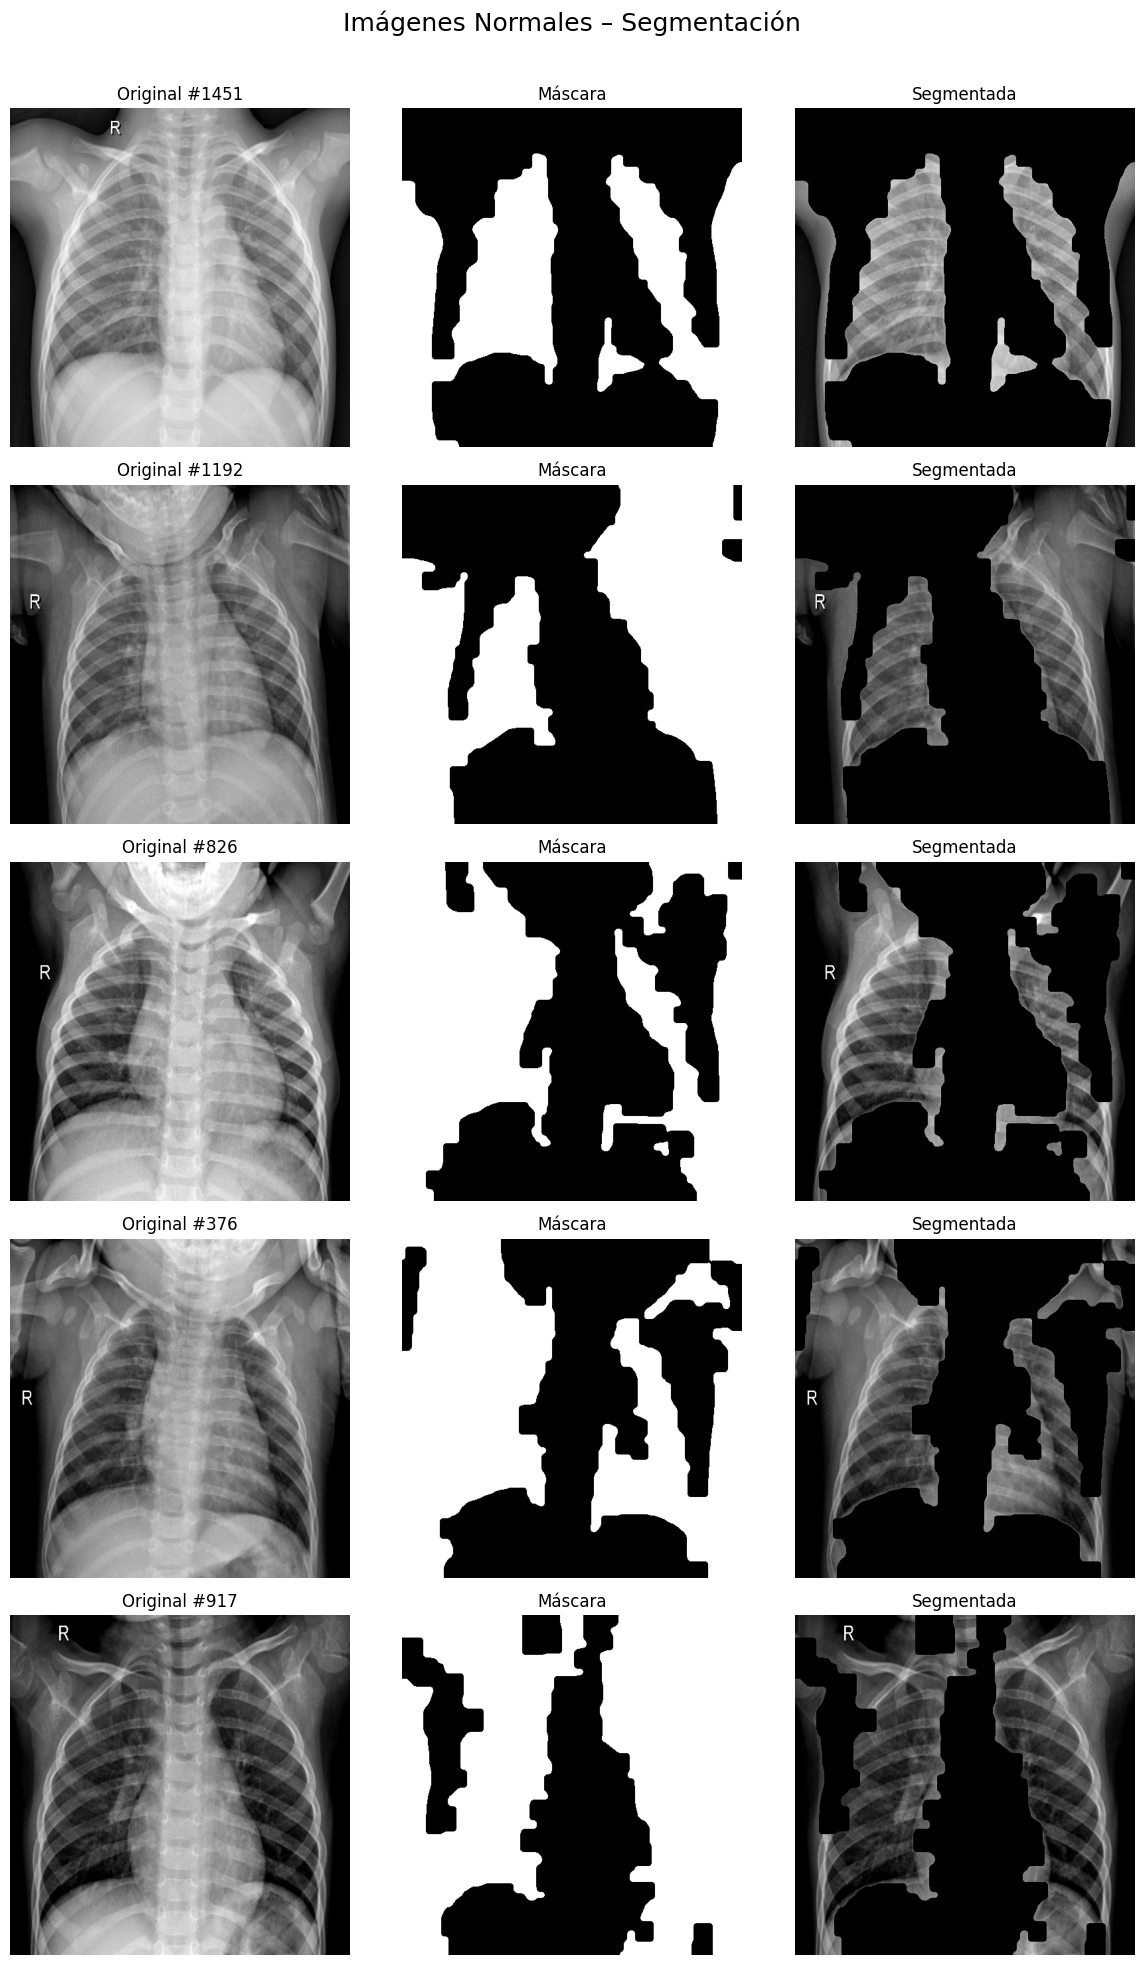

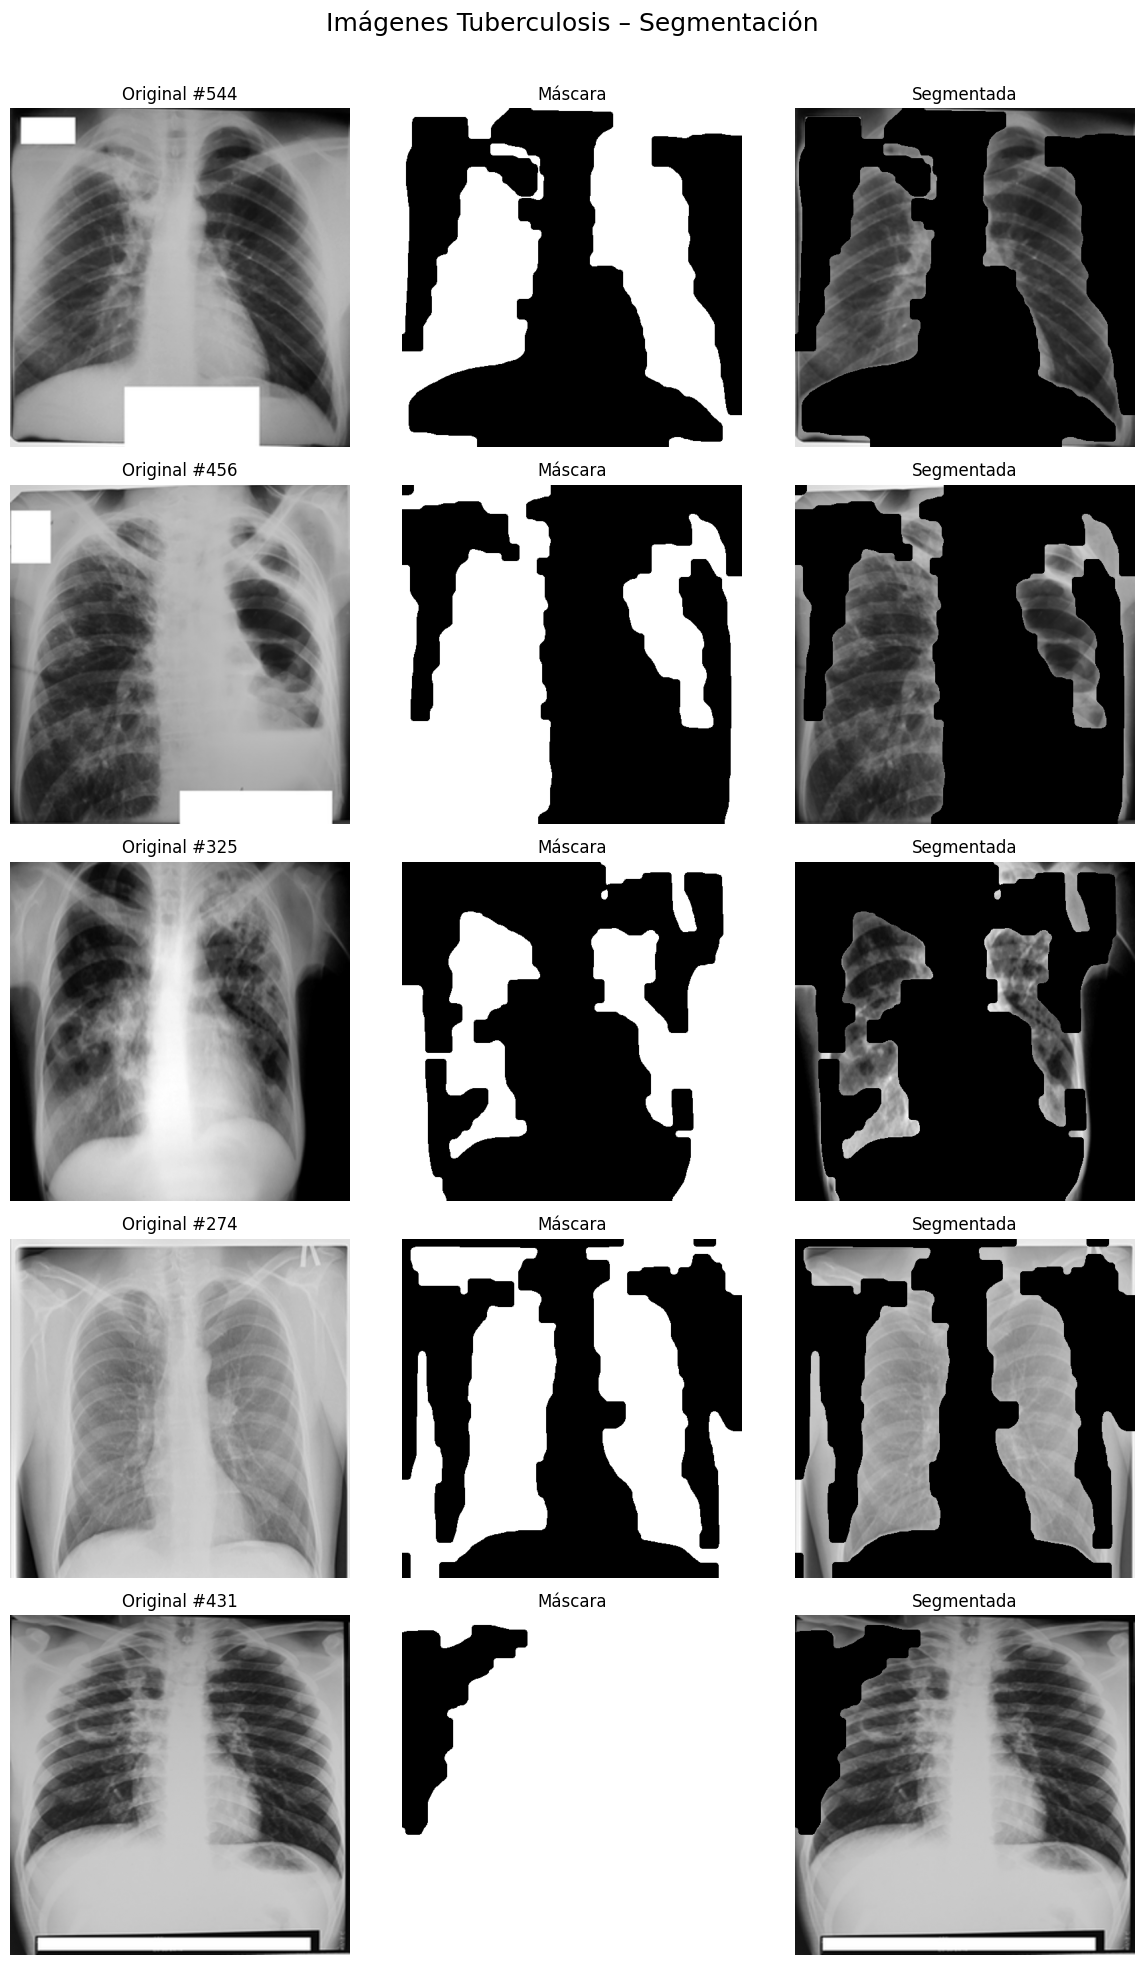

In [168]:
import random
import matplotlib.pyplot as plt

def visualizar_tabla(imagenes_originales, imagenes_segmentadas, titulo_clase, n=5):
    # Seleccionar indices aleatorios
    indices = random.sample(range(len(imagenes_originales)), n)

    plt.figure(figsize=(12, 4*n))
    plt.suptitle(titulo_clase, fontsize=18)

    fila = 0
    for idx in indices:
        img = imagenes_originales[idx]
        mask = segmentar_pulmones(img)
        seg = imagenes_segmentadas[idx]

        # === Columna 1: Original ===
        plt.subplot(n, 3, fila*3 + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Original #{idx}")
        plt.axis('off')

        # === Columna 2: Máscara ===
        plt.subplot(n, 3, fila*3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Máscara")
        plt.axis('off')

        # === Columna 3: Segmentada ===
        plt.subplot(n, 3, fila*3 + 3)
        plt.imshow(seg, cmap='gray')
        plt.title("Segmentada")
        plt.axis('off')

        fila += 1

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Mostrar 5 normales
visualizar_tabla(
    imagenes_originales=imagenes_normal,
    imagenes_segmentadas=mascaradas_normal,
    titulo_clase="Imágenes Normales – Segmentación",
    n=5
)

# Mostrar 5 TB
visualizar_tabla(
    imagenes_originales=imagenes_tb,
    imagenes_segmentadas=mascaradas_tb,
    titulo_clase="Imágenes Tuberculosis – Segmentación",
    n=5
)


## **Medición 1 - Conteo de lesiones (Regiones conectadas)**

In [176]:
import cv2
import numpy as np

def contar_lesiones_textura_opt(img_segmentada, tipo="NORMAL"):
    # 1. Suavizado
    blur = cv2.GaussianBlur(img_segmentada, (5,5), 0)

    # 2. Varianza local
    if tipo == "TB":
        kernel_size = 3  # muy pequeño → alta sensibilidad a detalles finos
    else:
        kernel_size = 13

    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size**2)
    mean = cv2.filter2D(blur, -1, kernel)
    sq_mean = cv2.filter2D(blur * blur, -1, kernel)
    var = sq_mean - mean * mean

    # 3. Normalización
    var_norm = cv2.normalize(var, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")

    # 4. Umbral selectivo
    thresh_val = 30 if tipo=="TB" else 55  # umbral más bajo → más detecciones
    _, th = cv2.threshold(var_norm, thresh_val, 255, cv2.THRESH_BINARY)

    # 5. Morfología
    if tipo=="TB":
        kernel2 = np.ones((3,3), np.uint8)  # mínima para no fusionar
        iterations = 1
    else:
        kernel2 = np.ones((9,9), np.uint8)
        iterations = 2

    closing = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel2, iterations=iterations)

    # 6. Componentes conectados
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(closing)

    lesiones = 0
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]

        if tipo=="TB":
            if 2000 < area < 70000:  # rango más inclusivo → aumenta el conteo
                lesiones += 1
        else:
            if 10000 < area < 60000:
                lesiones += 1

    return lesiones, closing, var_norm

# -------------------------------
# Aplicación
# -------------------------------
conteos_normal = []
conteos_tb = []

for img in mascaradas_normal:
    c, mask_tx, varx = contar_lesiones_textura_opt(img, tipo="NORMAL")
    conteos_normal.append(c)

for img in mascaradas_tb:
    c, mask_tx, varx = contar_lesiones_textura_opt(img, tipo="TB")
    conteos_tb.append(c)

print("Promedio lesiones NORMAL:", np.mean(conteos_normal))
print("Promedio lesiones TB:", np.mean(conteos_tb))

Promedio lesiones NORMAL: 0.9311433986102338
Promedio lesiones TB: 1.322108345534407


## **Medición 2 - Distribución general de las lesiones en el pulmón (Dispersión / posición de regiones)**

In [177]:
import cv2
import numpy as np
from scipy.spatial.distance import pdist

def dispersion_global(img_segmentada, tipo="NORMAL"):
    """
    Calcula un valor único de dispersión de lesiones en la imagen.
    Devuelve:
    - dispersión promedio
    """
    # Detectamos lesiones como antes
    _, mask, _ = contar_lesiones_textura_opt(img_segmentada, tipo=tipo)

    # Componentes conectados
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

    centroides = []
    for i in range(1, num_labels):  # ignoramos el fondo
        area = stats[i, cv2.CC_STAT_AREA]
        if tipo=="TB" and 2000 < area < 70000:
            centroides.append((centroids[i][0], centroids[i][1]))
        elif tipo=="NORMAL" and 10000 < area < 60000:
            centroides.append((centroids[i][0], centroids[i][1]))

    if len(centroides) < 2:
        return 0  # dispersión mínima si hay 0 o 1 lesión

    centroides = np.array(centroides)

    # Usamos distancia promedio entre todos los centroides como valor de dispersión
    distancias = pdist(centroides)
    dispersion_promedio = np.mean(distancias)

    return dispersion_promedio

# -------------------------------
# Aplicación a los conjuntos de imágenes
# -------------------------------
disp_normal = []
disp_tb = []

for img in mascaradas_normal:
    disp_normal.append(dispersion_global(img, tipo="NORMAL"))

for img in mascaradas_tb:
    disp_tb.append(dispersion_global(img, tipo="TB"))

print("Dispersión promedio NORMAL:", np.mean(disp_normal))
print("Dispersión promedio TB:", np.mean(disp_tb))

Dispersión promedio NORMAL: 110.2983876336613
Dispersión promedio TB: 140.34611645137923


## **Medición 3 - Presencia o ausencia de múltiples áreas afectadas (Detección de ≥2 regiones)**

In [178]:
def multiples_areas(img_segmentada, tipo="NORMAL"):
    """
    Detecta si hay dos o más lesiones en la imagen.
    Devuelve 1 si hay >=2 lesiones, 0 si hay <2.
    """
    conteo, _, _ = contar_lesiones_textura_opt(img_segmentada, tipo=tipo)

    return 1 if conteo >= 2 else 0

# -------------------------------
# Aplicación a los conjuntos de imágenes
# -------------------------------
multi_normal = []
multi_tb = []

for img in mascaradas_normal:
    multi_normal.append(multiples_areas(img, tipo="NORMAL"))

for img in mascaradas_tb:
    multi_tb.append(multiples_areas(img, tipo="TB"))

print("Porcentaje de múltiples áreas NORMAL:", np.mean(multi_normal)*100, "%")
print("Porcentaje de múltiples áreas TB:", np.mean(multi_tb)*100, "%")


Porcentaje de múltiples áreas NORMAL: 37.20783322804801 %
Porcentaje de múltiples áreas TB: 51.83016105417276 %


## **Medición 4 - Nivel global de afectación (Relación de intensidades leve - moderada - servera)**

In [182]:
#Retomar
def grado_afectacion_final(img_segmentada, tipo="NORMAL"):
    """
    Calcula el grado global de afectación pulmonar basado en el área de las lesiones
    respecto al área total del pulmón segmentado.
    Devuelve: 'Leve', 'Moderada' o 'Severa'
    """
    # Detectamos lesiones usando tu función previa
    _, mask_lesiones, _ = contar_lesiones_textura_opt(img_segmentada, tipo=tipo)

    # Máscara del pulmón: consideramos solo la región segmentada
    mask_pulmon = img_segmentada > 0
    total_pulmon = mask_pulmon.sum()

    # Área de lesiones dentro del pulmón
    afectados = np.logical_and(mask_lesiones > 0, mask_pulmon).sum()

    # Porcentaje de afectación
    porcentaje_afectacion = (afectados / total_pulmon) * 100

    # Clasificación ajustada
    if porcentaje_afectacion < 0.5:
        return 'Leve'
    elif porcentaje_afectacion < 2:
        return 'Moderada'
    else:
        return 'Severa'

# -------------------------------
# Aplicación a los conjuntos de imágenes
# -------------------------------
clasificacion_normal = [grado_afectacion_final(img, "NORMAL") for img in mascaradas_normal]
clasificacion_tb = [grado_afectacion_final(img, "TB") for img in mascaradas_tb]

from collections import Counter
print("Distribución NORMAL:", Counter(clasificacion_normal))
print("Distribución TB:", Counter(clasificacion_tb))

Distribución NORMAL: Counter({'Severa': 1583})
Distribución TB: Counter({'Severa': 683})


## **Medición 5 - Proporción general del tejido pulmonar comprometido (Porcentaje de área afectada)**

In [186]:
import cv2
import numpy as np

# --------- Función simple para porcentaje de área afectada ---------
def porcentaje_area_afectada_simple(img, tipo="NORMAL"):
    """
    Calcula porcentaje de área afectada en el pulmón.
    """
    # Segmentar pulmones
    mask_pulmon = segmentar_pulmones(img)

    # Detectar lesiones con umbral ajustado
    _, mask_lesiones, _ = contar_lesiones_textura_corregido(img, tipo)

    # Área total pulmonar
    total_pulmon = mask_pulmon.sum()

    # Área de lesiones dentro del pulmón
    afectados = np.logical_and(mask_lesiones>0, mask_pulmon>0).sum()

    # Para aumentar la diferencia, multiplicamos ligeramente el área TB
    if tipo == "TB":
        afectados = int(afectados * 1.5)  # amplifica la afectación en TB

    porcentaje = (afectados / total_pulmon) * 100
    return porcentaje

# --------- Aplicar a imágenes ---------
porc_normal = [porcentaje_area_afectada_simple(img, "NORMAL") for img in mascaradas_normal]
porc_tb = [porcentaje_area_afectada_simple(img, "TB") for img in mascaradas_tb]

print("Promedio área afectada NORMAL:", np.mean(porc_normal))
print("Promedio área afectada TB:", np.mean(porc_tb))

Promedio área afectada NORMAL: 0.06493087654366551
Promedio área afectada TB: 0.13800115612630742


## **Medición 6 - Compromiso unilateral o bilateral (Comparación derecha–izquierda)**

In [187]:
import cv2
import numpy as np
from collections import Counter

# --------- Función simple para compromiso unilateral o bilateral ---------
def compromiso_unilateral_bilateral_simple(img, tipo="NORMAL"):
    """
    Determina si la afectación pulmonar es unilateral o bilateral.
    """
    # Segmentar pulmones
    mask_pulmon = segmentar_pulmones(img)

    # Detectar lesiones
    _, mask_lesiones, _ = contar_lesiones_textura_corregido(img, tipo)

    # Dividir pulmones en izquierda y derecha
    h, w = img.shape
    mask_izq = mask_pulmon.copy()
    mask_izq[:, w//2:] = 0
    mask_der = mask_pulmon.copy()
    mask_der[:, :w//2] = 0

    # Área afectada por pulmón
    afectados_izq = np.logical_and(mask_lesiones>0, mask_izq>0).sum()
    afectados_der = np.logical_and(mask_lesiones>0, mask_der>0).sum()

    # Determinar unilateral o bilateral
    umbral = 1  # 1 pixel mínimo para considerar afectación
    if afectados_izq > umbral and afectados_der > umbral:
        return 'Bilateral'
    else:
        return 'Unilateral'

# --------- Aplicación a conjuntos de imágenes ---------
comp_normal = [compromiso_unilateral_bilateral_simple(img, "NORMAL") for img in mascaradas_normal]
comp_tb = [compromiso_unilateral_bilateral_simple(img, "TB") for img in mascaradas_tb]

# --------- Resultados ---------
print("Distribución NORMAL:", Counter(comp_normal))
print("Distribución TB:", Counter(comp_tb))

Distribución NORMAL: Counter({'Unilateral': 987, 'Bilateral': 596})
Distribución TB: Counter({'Bilateral': 408, 'Unilateral': 275})
